# Introduksjon

I denne notebooken skal vi illustrere hvordan maskinlæring kan brukes på helsejournaldata via et (lite) eksempel. Se introslides til Lab 1 for motivasjon til problemstillingen.

Fra data samlet inn fra 100.000 pasienter og tilrettelagt og tilgjengeliggjort av Microsoft https://microsoft.github.io/r-server-hospital-length-of-stay/index.html skal vi forsøke å forutsi liggetiden til pasienter som legges inn på sykehuset. Et slikt system (om det var tilstrekkelig robust og nøyaktig nok) ville vært svært nyttig for ressursfordeling på et sykehus, blant annet for fordeling av personell og for planlegging av utskrivninger ved en avdeling. Ved å undersøke hvilke egenskaper som gir størst forklaringsverdi for systemet kan en også (potensielt) avdekke interessante sammenhenger mellom journaldata og pasienters tilstand. 

# Setup

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from pathlib import Path

In [2]:
DATA = Path('../data/hospital')

# Les inn og se på data

Datasettet består av tre filer:

In [3]:
LOS = pd.read_pickle(DATA/'hospital')
DICT = pd.read_excel(DATA/'Data_Dictionary.xlsx')
METADATA = pd.read_csv(DATA/'MetaData_Facilities.csv')

Vi tar en titt på alle tre:

In [4]:
LOS.head()

,rcount,gender,facid,eid,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,neutrophils,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,lengthofstay
0,0,0,1,1,False,False,False,False,False,False,...,14.20,140.361130,192.476913,12.0,1.390722,30.432417,96,6.5,4,3
1,5,0,0,2,False,False,False,False,False,False,...,4.10,136.731689,94.078506,8.0,0.943164,28.460516,61,6.5,1,7
2,1,0,1,3,False,False,False,False,False,False,...,8.90,133.058517,130.530518,12.0,1.065750,28.843811,64,6.5,2,3
3,0,0,0,4,False,False,False,False,False,False,...,9.40,138.994019,163.377029,12.0,0.906862,27.959007,76,6.5,1,1
4,0,0,4,5,False,False,False,True,False,True,...,9.05,138.634842,94.886658,11.5,1.242854,30.258926,67,5.6,2,4


In [5]:
LOS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 26 columns):
rcount                        100000 non-null int32
gender                        100000 non-null int32
facid                         100000 non-null int32
eid                           100000 non-null int32
dialysisrenalendstage         100000 non-null bool
asthma                        100000 non-null bool
irondef                       100000 non-null bool
pneum                         100000 non-null bool
substancedependence           100000 non-null bool
psychologicaldisordermajor    100000 non-null bool
depress                       100000 non-null bool
psychother                    100000 non-null bool
fibrosisandother              100000 non-null bool
malnutrition                  100000 non-null bool
hemo                          100000 non-null bool
hematocrit                    100000 non-null float32
neutrophils                   100000 non-null float32
sodium       

In [6]:
DICT

,Index,Data fields,Type,Descriptions
0,NaN,LengthOfStay,NaN,NaN
1,1.0,eid,Integer,Unique Id of the hospital admission
2,2.0,vdate,String,Visit date
3,3.0,rcount,Integer,Number of readmissions within last 180 days
4,4.0,gender,String,Gender of the patient\nM or F
5,5.0,dialysisrenalendstage,String,Flag for renal disease during encounter
6,6.0,asthma,String,Flag for asthma during encounter
7,7.0,irondef,String,Flag for iron deficiency during encounter
8,8.0,pneum,String,Flag for pneumonia during encounter
9,9.0,substancedependence,String,Flag for substance dependence during encounter


In [7]:
METADATA

,Capacity,Id,Name
0,30,C,General Medicine 3 South
1,95,E,Behavioral 1 East
2,75,A,General Medicine 3 West
3,80,B,Pulmonary 2 West
4,100,D,Geriatrics 2 East


## Observasjoner hittil

Det ser ut som at `LOS` er vår hovedkilde. `DICT` gir oss nyttig informasjon om features i `LOS`, mens `METADATA` har informasjon om de ulike avdelingene data er samlet fra. 

> **OBS:** Vi har endret litt på features i vår versjon av `LOS` i forhold til <a href="https://github.com/Microsoft/r-server-hospital-length-of-stay/raw/master/Data/LengthOfStay.csv">orginalen</a>: <br> - Vi har slått sammen alle opphold på lengre enn 8 dager, <br> - Alle `rcount` markert som "5+" er satt til 5. 

# Plots og videre utforsking

Hva er fordelingen av pasientopphold? 

In [8]:
LOS_value_count = LOS['lengthofstay'].value_counts()
LOS_value_count

1              17979
3              16068
4              14822
2              12825
5              12116
6              10362
7               7263
8               4652
more than 8     3913
Name: lengthofstay, dtype: int64

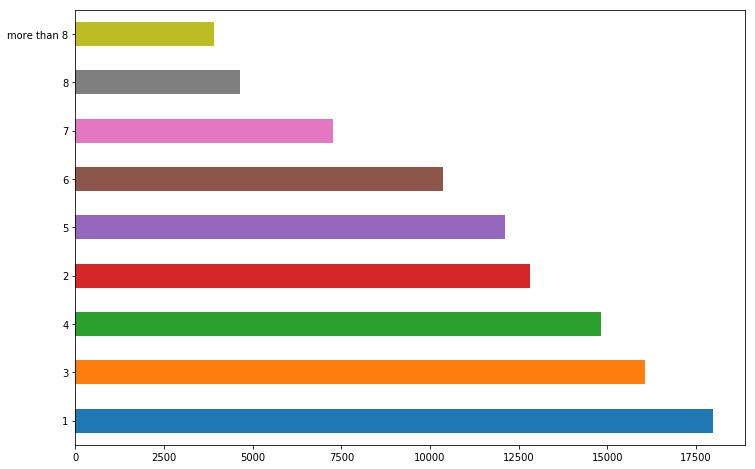

In [9]:
LOS_value_count.plot.barh(figsize=(12,8))
plt.show()

Vi ser at datasettet er ganske skjevt fordelt. De aller fleste opphold på sykehuset er korte. 

Hvordan er kjønnsfordelingen?

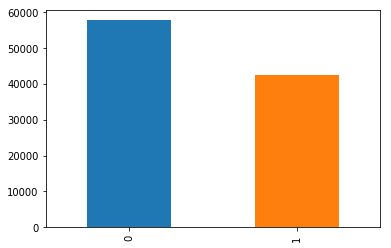

In [10]:
gender_counts = LOS['gender'].value_counts()
gender_counts.plot.bar()
plt.show()

Litt flere menn (0) enn kvinner (1). 

Hvor lenge oppholder de seg på sykehuset?

In [11]:
# Vi konverterer først "mer enn 8" til tallet 9:
LOS_tmp = LOS.copy()

C:\Users\alexa\Anaconda3\envs\elmed219\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


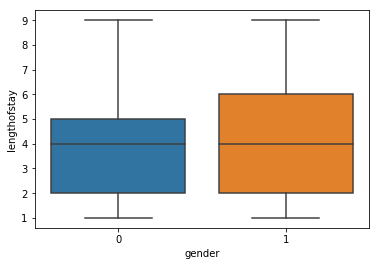

In [12]:
LOS_tmp['lengthofstay'].loc[LOS_tmp['lengthofstay'] == 'more than 8'] = 9 # Setter alle med "mer enn 8" til 9

LOS_tmp['lengthofstay'] = LOS_tmp['lengthofstay'].astype(int) # Skift til heltall

# Box plot:
ax = sns.boxplot(x='gender', y='lengthofstay', data=LOS_tmp)

## Korrelasjoner

Hvordan korrelerer de numeriske features i datasettet til liggetiden?

Her var beskrivelsen av features:

In [13]:
DICT

,Index,Data fields,Type,Descriptions
0,NaN,LengthOfStay,NaN,NaN
1,1.0,eid,Integer,Unique Id of the hospital admission
2,2.0,vdate,String,Visit date
3,3.0,rcount,Integer,Number of readmissions within last 180 days
4,4.0,gender,String,Gender of the patient\nM or F
5,5.0,dialysisrenalendstage,String,Flag for renal disease during encounter
6,6.0,asthma,String,Flag for asthma during encounter
7,7.0,irondef,String,Flag for iron deficiency during encounter
8,8.0,pneum,String,Flag for pneumonia during encounter
9,9.0,substancedependence,String,Flag for substance dependence during encounter


Vi undersøker korrelasjonene med 'lengthofstay':

In [14]:
correlation_matrix = LOS_tmp.corr()
correlation_matrix['lengthofstay'].sort_values(ascending=False)

lengthofstay                  1.000000
rcount                        0.752818
facid                         0.363066
psychologicaldisordermajor    0.289187
hemo                          0.213832
irondef                       0.192063
psychother                    0.185655
malnutrition                  0.169207
dialysisrenalendstage         0.162927
substancedependence           0.147174
bloodureanitro                0.141912
pneum                         0.132303
depress                       0.122732
asthma                        0.084388
gender                        0.068686
fibrosisandother              0.060492
pulse                         0.006616
secondarydiagnosisnonicd9     0.006339
eid                           0.001203
bmi                          -0.000181
glucose                      -0.002465
sodium                       -0.002510
creatinine                   -0.004156
neutrophils                  -0.011813
respiration                  -0.019343
hematocrit               

## Observasjoner

- `rcount` er svært korrelert med liggetid. Antall besøk i løpet av siste 180 dager forteller mye om forventet liggetid. 
- `facid` har også relativt høy korrelasjon. Det kan skyldes at de ulike avdelingene har ulik kapasitet og roller med hensyn på befolkningen de tjener.

De fleste har ikke vært på sykehuset tidligere i løpet av siste halvår, men en god del har hyppige besøk:

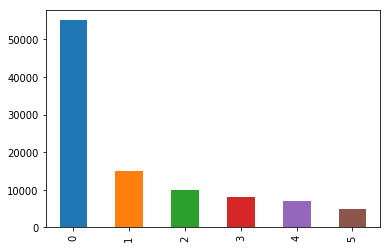

In [15]:
LOS['rcount'].value_counts().plot.bar()
plt.show()

Kapasiteten til de ulike avdelingene varierer:

In [16]:
METADATA

,Capacity,Id,Name
0,30,C,General Medicine 3 South
1,95,E,Behavioral 1 East
2,75,A,General Medicine 3 West
3,80,B,Pulmonary 2 West
4,100,D,Geriatrics 2 East


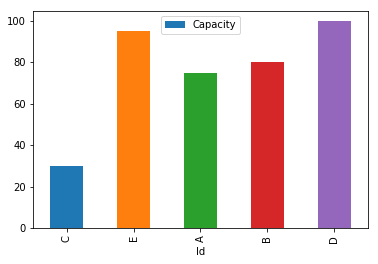

In [17]:
METADATA.plot(x='Id', y='Capacity', kind='bar')
plt.show()

# Prediksjon

Vi velger å angripe problemet med å predikere liggetid som et klassifikasjonsproblem: altså, 
> Er forventet liggetid 0, 1, 2, 3, 4, 5, 6, 7, 8, eller mer enn 8 dager?

Det er også mulig å sette opp en regresjonsmodell for dette problemet. Du må gjerne forsøke det!

In [18]:
X = LOS.drop('lengthofstay', axis=1)
y = LOS['lengthofstay']

## Hold av et testsett til å evaluere modellen

For å simulere den relle situasjonen der vår modell skal brukes til å predikere liggetid i det en ny pasient kommer inn holder vi av et testdatasett for å evaluere modellen. Dette er til for å simulere den reelle situasjonen. 

In [19]:
from sklearn.model_selection import train_test_split

Vi bruker stratifisert splitting (`stratify=y` nedenfor) for å sikre at fordelingen av liggetider blir den samme i treningsdata som i testdata. 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

## Velg modell

Vi forsøker en random forest klassifikator:

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) 
# n_jobs=-1 for å bruke alle tilgjenglige CPUer på maskinen

Vi trener modellen:

In [23]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

...og beregner accuracy på test-data:

In [24]:
from sklearn.metrics import accuracy_score

In [25]:
y_pred = rf.predict(X_test)

In [26]:
accuracy_score(y_test, y_pred)

0.66676

Vi predikerer altså liggetiden med ca. 67% nøyaktighet. 

# Evaluering av resultatet

Er dette en god nøyaktighet? Hvilke features bruker modellen til sine prediksjoner?

## Forvirringsmatrise

Som vanlig vil forvirringsmatriser fortelle oss mye om en klassifikators ytelse.

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [28]:
from utils import plot_confusion_matrix

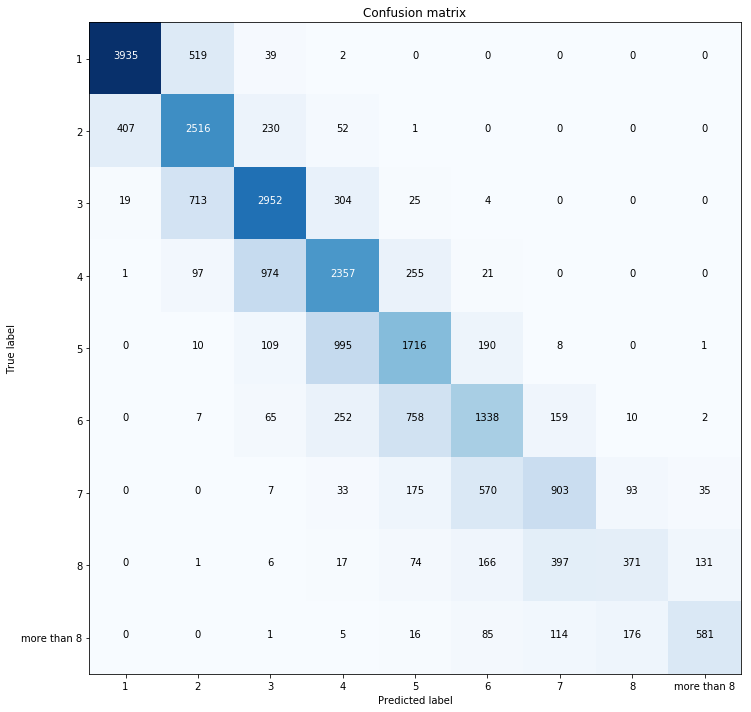

In [29]:
fig, ax = plt.subplots(figsize=(12,10))
_ = plot_confusion_matrix(cm, classes=np.unique(y_test), ax=ax)

## Feature importance

In [30]:
importances = rf.feature_importances_
# Find index of those with highest importance, sorted from largest to smallest:
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]): 
    print(f'{X.columns[indices[f]]}: {np.round(importances[indices[f]],2)}')

rcount: 0.22
bmi: 0.08
creatinine: 0.08
glucose: 0.08
sodium: 0.08
pulse: 0.07
hematocrit: 0.07
neutrophils: 0.06
eid: 0.05
facid: 0.04
respiration: 0.04
bloodureanitro: 0.04
secondarydiagnosisnonicd9: 0.03
psychologicaldisordermajor: 0.02
hemo: 0.01
gender: 0.01
irondef: 0.01
substancedependence: 0.01
dialysisrenalendstage: 0.01
depress: 0.01
asthma: 0.0
pneum: 0.0
malnutrition: 0.0
psychother: 0.0
fibrosisandother: 0.0


Vi ser at modellen lener seg veldig mye på `rcount`, altså antall ganger personen har vært på sykehuset siste 180 dager.. Dette er ikke overraskende hvis vi husker tilbake til korrelasjonene vi undersøkte tidligere. Mer om det etterpå.

Som vi husker fra `ELMED219-ML-1-Enkle_eksempler.ipynb` bør en ikke stole for mye på feature importances i random forest-modeller. Det er bedre å bruke **permutation importance**

## Permutation importance

In [31]:
import eli5
from eli5.sklearn import PermutationImportance

In [32]:
perm = PermutationImportance(rf, random_state=42).fit(X_test, y_test)

In [33]:
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.3913 ± 0.0037,rcount
0.1097 ± 0.0028,psychologicaldisordermajor
0.0772 ± 0.0041,facid
0.0728 ± 0.0038,hematocrit
0.0622 ± 0.0031,bmi
0.0592 ± 0.0036,creatinine
0.0564 ± 0.0033,sodium
0.0547 ± 0.0013,glucose
0.0524 ± 0.0028,pulse
0.0456 ± 0.0023,respiration


Vi ser også her at modellen bruker `rcount` som sin viktigste feature, med god margin. 

> **Din tur!** En hypotese om hvorfor `psychologicaldisordermajor` havner såpass høyt oppe er at personer med dette flagget satt til True er spesielle. Blant annet kan det tenkes at de ofte ligger på avdelingen "Behavioral". Undersøk dette. Undersøk gjerne også andre hypoteser du måtte komme på. 

Et naturlig spørsmål: er det slik at om antall besøk øker, så øker også forventet liggetid? Eller motsatt? Eller er det en mer komplisert sammenheng? 

Dette kan vi (til dels) undersøke ved å bruke våre **partial dependence plots**, som også ble innført i `ELMED219-ML-1-Enkle_eksempler.ipynb`.

## Partial dependence plots

In [34]:
from pdpbox import pdp

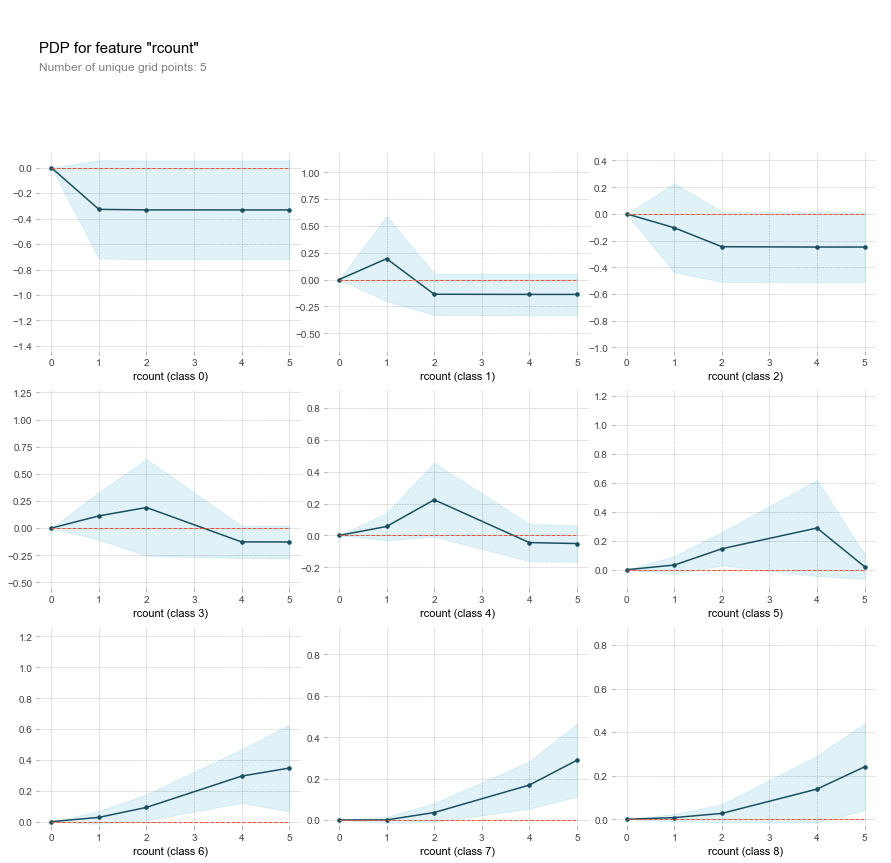

In [35]:
pdp_goals = pdp.pdp_isolate(model=rf, dataset=X_test, model_features=X_test.columns.tolist(), feature='rcount', n_jobs=-1)
pdp.pdp_plot(pdp_goals, 'rcount', ncols=3)
plt.show()

Vi ser at for de korte oppholdene øker ikke forventet antall dager med antall sykehusbesøk. For oppholdene på 6 dager eller mer er det derimot en slik sammenheng. 

> **Din tur!** Hva slags lidelser (av de som er registrert i datasettet vårt) karakteriserer pasienter som har høy `rcount`?

# Feature engineering

Vi har observert at visse features i datasettet er viktigere enn andre for vår modell. Noen features beskriver pasientene på enn mer *hensiktsmessig* måte enn andre. Det vil si, med høyere verdi for vår modells prediksjoner av liggetid. 

> Men det er ingenting som tilsier at dette er de *beste* mulige features for pasientene! 

En av de aller viktigste delene av maskinlæring (men også svært undervurdert i mer «teoretiske» vinklinger på feltet) er såkalt **feature engineering**. 

Maskinlæring handler i bunn og grunn om **å tilnærme funksjoner**. En ønsker å finne en funksjon som er så nært som mulig *fasit-funksjonen*: den som sender mengden av features til en instans til korrekt output. Det vil si, til korrekt klasse om klassifikasjon, til korrekt verdi om regresjon. 

> Jo mer *komplisert* fasit-funksjonen er jo vanskeligere er det for maskinlæringsmodellen å tilnærme seg denne. 

Ved å beskrive rådata med nye, bedre egnede features kan en gjøre fasit-funksjonen mindre komplisert. Som et ekstremt eksempel: om vi hadde lagt til innleggingsdato og utskrivningsdato til hver pasient som features i vårt datasett hadde fasitfunksjonen vært veldig enkel: utskrivningsdato minus innleggingsdato er lik antall liggedøgn. 

Det er stort handlingsrom mellom å gjøre ingenting og å rett og slett legge til fasit som en feature (noe som ikke er nyttig)!

Det aller beste er om man kan justere på hvordan datainnsamlingen er gjort. Da kan en legge til helt nye features som en tror kan være nyttige for modelleringen (f.eks. legge til alder som en feature i våre data). 

Hvis man ikke kan endre på hvilke data som er samlet inn kan man tenke følgende: (i) hente inn eksterne features (f.eks. om vi hadde hatt personnummeret til pasientene kunne vi slått dette opp for å finne mer informasjon), eller (ii) lage nye features ved å kombinere de vi har. 

> Ethvert maskinlæringsprosjekt vil ha innslag av disse former for feature engineering! (Deep learning er et slags unntak; mer om det senere).

## En ny feature: Antall problemer per pasient

Hver pasient er tilordnet en rekke flagg av ulike problemer: 
```
 'dialysisrenalendstage',
 'asthma',
 'irondef',
 'pneum',
 'substancedependence',
 'psychologicaldisordermajor',
 'depress',
 'psychother',
 'fibrosisandother',
 'malnutrition',
 'hemo'
 ```

In [36]:
LOS.head()

,rcount,gender,facid,eid,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,neutrophils,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,lengthofstay
0,0,0,1,1,False,False,False,False,False,False,...,14.20,140.361130,192.476913,12.0,1.390722,30.432417,96,6.5,4,3
1,5,0,0,2,False,False,False,False,False,False,...,4.10,136.731689,94.078506,8.0,0.943164,28.460516,61,6.5,1,7
2,1,0,1,3,False,False,False,False,False,False,...,8.90,133.058517,130.530518,12.0,1.065750,28.843811,64,6.5,2,3
3,0,0,0,4,False,False,False,False,False,False,...,9.40,138.994019,163.377029,12.0,0.906862,27.959007,76,6.5,1,1
4,0,0,4,5,False,False,False,True,False,True,...,9.05,138.634842,94.886658,11.5,1.242854,30.258926,67,5.6,2,4


In [37]:
DICT

,Index,Data fields,Type,Descriptions
0,NaN,LengthOfStay,NaN,NaN
1,1.0,eid,Integer,Unique Id of the hospital admission
2,2.0,vdate,String,Visit date
3,3.0,rcount,Integer,Number of readmissions within last 180 days
4,4.0,gender,String,Gender of the patient\nM or F
5,5.0,dialysisrenalendstage,String,Flag for renal disease during encounter
6,6.0,asthma,String,Flag for asthma during encounter
7,7.0,irondef,String,Flag for iron deficiency during encounter
8,8.0,pneum,String,Flag for pneumonia during encounter
9,9.0,substancedependence,String,Flag for substance dependence during encounter


La oss lage en ny feature som teller antall problemer per pasient. Tanken er at antall problemer en pasient har påvirker liggetiden. Om vi legger dette til som en feature gjør vi det enklere for modellen å plukke opp en slik sammenheng. 

Vi forsøker:

In [38]:
issues = ['dialysisrenalendstage',
 'asthma',
 'irondef',
 'pneum',
 'substancedependence',
 'psychologicaldisordermajor',
 'depress',
 'psychother',
 'fibrosisandother',
 'malnutrition',
 'hemo']

In [39]:
# Vi legger til summen av antall problemer som en feature, helt på slutten i vår data frame:
LOS.insert(len(LOS.columns)- 1, 'numberofissues', LOS[issues].astype('int').sum(axis=1))

In [40]:
LOS.head()

,rcount,gender,facid,eid,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,numberofissues,lengthofstay
0,0,0,1,1,False,False,False,False,False,False,...,140.361130,192.476913,12.0,1.390722,30.432417,96,6.5,4,0,3
1,5,0,0,2,False,False,False,False,False,False,...,136.731689,94.078506,8.0,0.943164,28.460516,61,6.5,1,0,7
2,1,0,1,3,False,False,False,False,False,False,...,133.058517,130.530518,12.0,1.065750,28.843811,64,6.5,2,0,3
3,0,0,0,4,False,False,False,False,False,False,...,138.994019,163.377029,12.0,0.906862,27.959007,76,6.5,1,0,1
4,0,0,4,5,False,False,False,True,False,True,...,138.634842,94.886658,11.5,1.242854,30.258926,67,5.6,2,2,4


In [41]:
LOS['numberofissues'].value_counts()

0    57341
1    23350
2    11536
3     4660
4     2018
5      773
6      261
7       46
8       12
9        3
Name: numberofissues, dtype: int64

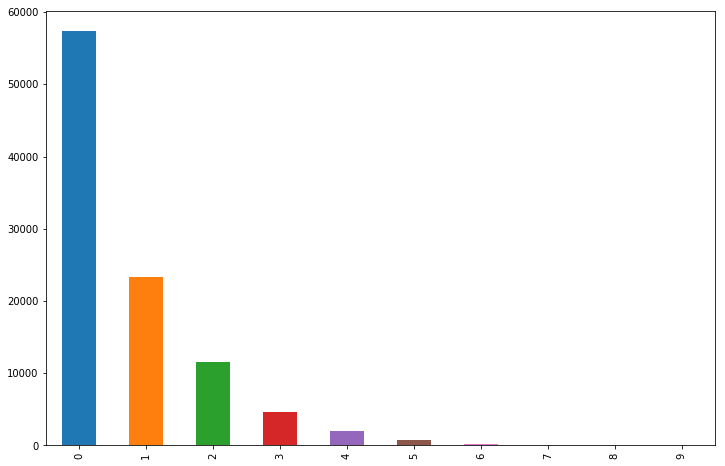

In [42]:
plt.figure(figsize=(12,8))
LOS['numberofissues'].value_counts().plot.bar()
plt.show()

> **Din tur!** Er pasienter med mange problemer ofte innlagt? Ligger de lenge?

## Lag modell med vår nye feature inkludert

In [43]:
X = LOS.drop('lengthofstay', axis=1)
y = LOS['lengthofstay']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

Vi trener en ny random forest klassifikator:

In [45]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) 

In [46]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

...og beregner accuracy på test-data:

In [47]:
y_pred = rf.predict(X_test)

In [48]:
accuracy_score(y_test, y_pred)

0.67816

Vi predikerer altså liggetiden med ca. 68% nøyaktighet. Littegrann bedre enn forrige modell.

La oss se på feature importance og permutation importance for å undersøke hvor god vår nye feature er:

In [49]:
importances = rf.feature_importances_
# Find index of those with highest importance, sorted from largest to smallest:
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]): 
    print(f'{X.columns[indices[f]]}: {np.round(importances[indices[f]],2)}')

rcount: 0.23
creatinine: 0.08
glucose: 0.08
bmi: 0.08
sodium: 0.08
pulse: 0.07
hematocrit: 0.07
neutrophils: 0.05
numberofissues: 0.05
eid: 0.05
respiration: 0.04
bloodureanitro: 0.04
facid: 0.03
secondarydiagnosisnonicd9: 0.02
psychologicaldisordermajor: 0.01
gender: 0.01
hemo: 0.01
irondef: 0.0
substancedependence: 0.0
depress: 0.0
psychother: 0.0
pneum: 0.0
malnutrition: 0.0
dialysisrenalendstage: 0.0
asthma: 0.0
fibrosisandother: 0.0


Vi ser at modellen bruker `number_of_issues` mer aktivt enn hvert av flaggene. 

Hva med permutation importance?

In [50]:
perm = PermutationImportance(rf, random_state=42).fit(X_test, y_test)

In [51]:
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=None)

Weight,Feature
0.4000 ± 0.0026,rcount
0.2792 ± 0.0051,numberofissues
0.0683 ± 0.0018,hematocrit
0.0596 ± 0.0028,bmi
0.0560 ± 0.0036,glucose
0.0553 ± 0.0018,creatinine
0.0547 ± 0.0030,sodium
0.0512 ± 0.0032,pulse
0.0437 ± 0.0023,respiration
0.0239 ± 0.0020,neutrophils


Her ser vi virkelig effekten av vår nye feature! Den havnet på en klar andreplass, langt over de andre!

# Din tur!

Vi har lastet ned et annet klassifikasjonsdatasett og plassert det i katalogen `../data/liver/indian_liver_patient.csv`. Det består av data fra 416 <em>lever-pasienter</em> og 167 <em>ikke lever-pasienter</em> samlet inn i Andhra Pradesh, India. Datasettet er nærmere beskrevet her: https://archive.ics.uci.edu/ml/datasets/ILPD+(Indian+Liver+Patient+Dataset). Fra 10 features er oppgaven å predikere hvorvidt en instans svarer til en pasient eller ikke. 

Last inn data med Pandas, utforsk datasettet som over, og forsøk å predikere pasientstatus. 

**Hint:**

In [55]:
#DATA = Path('../data/liver')
#df = pd.read_csv(DATA_T/'indian_liver_patient.csv')

# Ekstramateriale

Vår accuracy på 68% er ikke særlig god. Det er mange standard måter å øke ytelse i maskinlæring. La oss nevne noen (dette blir fort teknisk; ikke la deg overvelde av de mange ukjente begreper og ideer):

1. Få tak i bedre data. Kanskje har en tenkt feil på problemet under datainnsamlingen? Er data formålsmessig samlet inn?
2. Få tak i mer data. "Ekte" data, syntetisert data, eller "lignende" data.
3. Lag nye, bedre features via feature engineering. Eventuelt, fjern unyttige features (slike kan ødelegge modellen ved at mer data kreves)
4. Preprosesser data bedre. Skalering, transformasjoner.
5. Bruk en bedre tilpasset modell. De fleste modeller kan "tunes" ved å velge bedre "hyperparametre". Slik kan de gjøres mer eller mindre kompliserte, noe som er nyttig når en skal tilnærme seg en fasitfunksjon av en gitt kompleksitet. «Everything should be made as simple as possible, but not simpler». Dette henger tett sammen med det som kalles "regularisering", "overfitting" og "underfitting". Ta en titt på notebooken `ELMED219-Extra-Intro_to_ML.ipynb` om du er spesielt interessert.
6. Bruk en bedre egnet modelltype. Kanskje har du valgt en type modell som er for simpel (for eksempel logistisk regresjon på for komplisert datasett). Eller kanskje for komplisert?
7. Bruk flere modeller sammen i et "ensemble". Hver modell kan for eksempel stemme på et resultat, og så kan en predikere basert på konsensus. "Wisdom of the crowd". Du kan også la hver modell basere seg på litt ulike features, slik at feilene hver modell gjør er mest mulig uavhengige av hverandre. Det er også mulig å bruke en modell til å lære hvordan en samling av ulike modeller best kan settes sammen. Eller sekvensielt lage modeller som forsøker å predikere feilene gjort av tidligere modeller, for slik å sammen minimere feil. 

I vårt tilfelle kan vi gjøre et forsøk på nummer 6: vi kan bruke en annen type modell enn random forest. 

## XGBoost

– En av de kraftigste modellene som finnes! (Sammen med dype nevrale nettverk og «deep learning»)

Vi skal ikke gå inn på hvordan XGBoost fungerer her, bare bruke modellen som en black box (du kan lese om modellen <a href="https://xgboost.readthedocs.io/en/latest/tutorials/model.html">her</a> eller <a href="http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting">her</a> eller <a href="https://campus.datacamp.com/courses/extreme-gradient-boosting-with-xgboost/classification-with-xgboost">her</a> om du er spesielt interessert). 

NB: om du ikke har xgboost installert, kjør følgende celle:

In [ ]:
#!pip install xgboost

In [56]:
from xgboost import XGBClassifier

In [57]:
xgb_clf = XGBClassifier()

In [58]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [59]:
xgb_clf.score(X_test, y_test)

0.57648

Umiddelbart er ikke dette særlig imponerende.. Dårligere resultat enn vi hadde med random forest! Men det er typisk for XGBoost! Default-verdiene for hyperparameterene i XGBoost (de som ble listet når vi skrev `.fit` over) er sjelden gode. En må velge parametre som er tilpasset problemet. 

Dette kan gjøres via såkalt **hyperparametersøk**. Dette er utenfor vårt pensum så vi dropper det her. Jeg har tatt et kort søk etter gode parametre (med `GridSearchCV` om du lurer) og endt opp med følgende. Et større søk gjennom flere alternativer kunne ført til bedre resultater. Se <a href="http://nbviewer.jupyter.org/github/alu042/DAT158ML/blob/master/Part4-tree_based_models/DAT158-Part4-4-Optimizing_XGBoost.ipynb">her</a> for tips om hvordan en kan optimere XGBoost (om du er særdeles interessert).

In [60]:
xgb_clf = XGBClassifier(max_depth=10, min_child_weight=10, random_state=0, n_estimators=300, n_jobs=-1)

In [61]:
#Advarsel: tar en god del tid å trene denne modellen
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=10, missing=None, n_estimators=300,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [62]:
xgb_clf.score(X_test, y_test)

0.73424

Modellen har en accuracy på 73.4%. La oss ta en titt på permutation importance for denne modellen. 

Advarsel: dette tar lang tid!

In [63]:
# På grunn av en bug i ELI5 når PermutationImportance brukes sammen med XGBoost 
# må vi først trene modellen på nytt på følgende vis (ikke på Pandas data frame, 
# men på Numpy array):
xgb_clf.fit(X_train.values, y_train.values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=10, missing=None, n_estimators=300,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [64]:
perm = PermutationImportance(xgb_clf, random_state=42)

In [ ]:
perm.fit(X_test.values, y_test.values)

In [ ]:
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Vi får:

<img width=30% src="assets/ehr-xgboost_perm_importance.png">